<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchinfo import summary

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

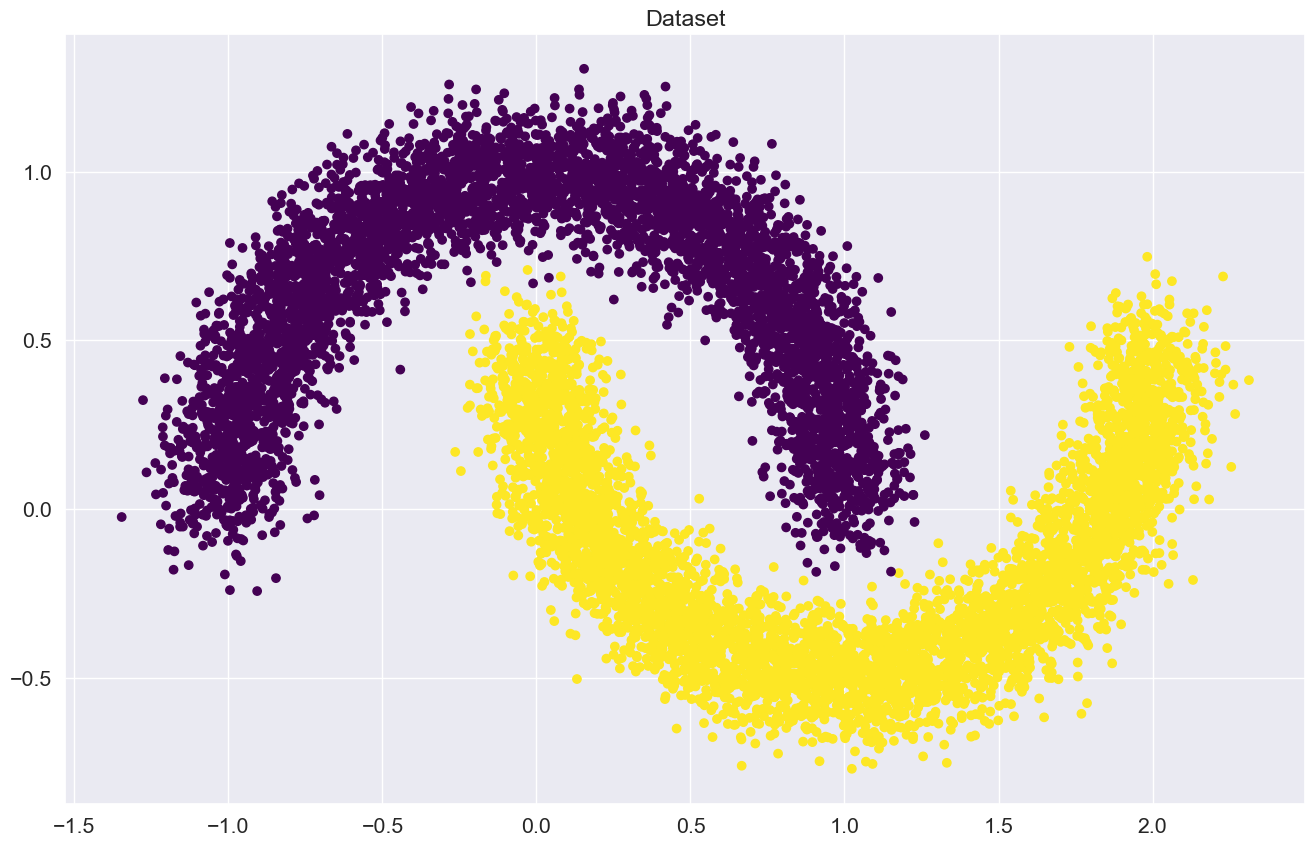

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t =  torch.tensor(X_val, dtype=torch.float32)
y_val_t =  torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, 1))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
pytorch_total_params = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)
pytorch_total_params

3

In [10]:
summary(linear_regression)

Layer (type:depth-idx)                   Param #
LinearRegression                         3
Total params: 3
Trainable params: 3
Non-trainable params: 0

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.view(outp.shape[0], 1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = outp.view(-1)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1940925598.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float32)
C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1940925598.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float32)


Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.8125
Iteration: 200
Batch accuracy: 0.84375
Iteration: 300
Batch accuracy: 0.8359375
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.8984375

Iteration: 523.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 523

### Визуализируем результаты

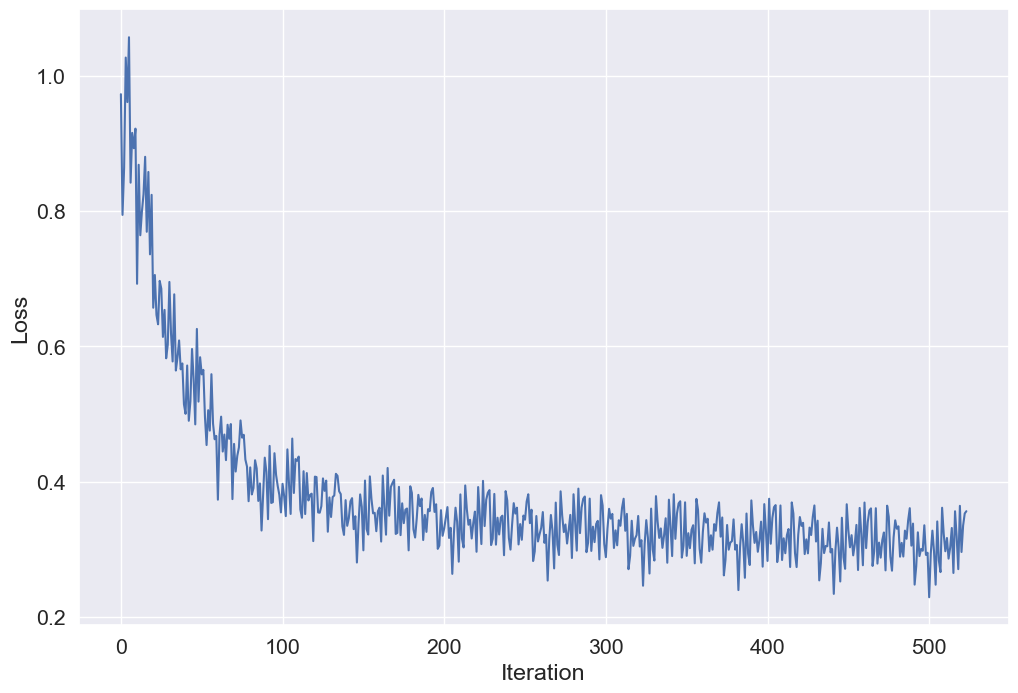

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

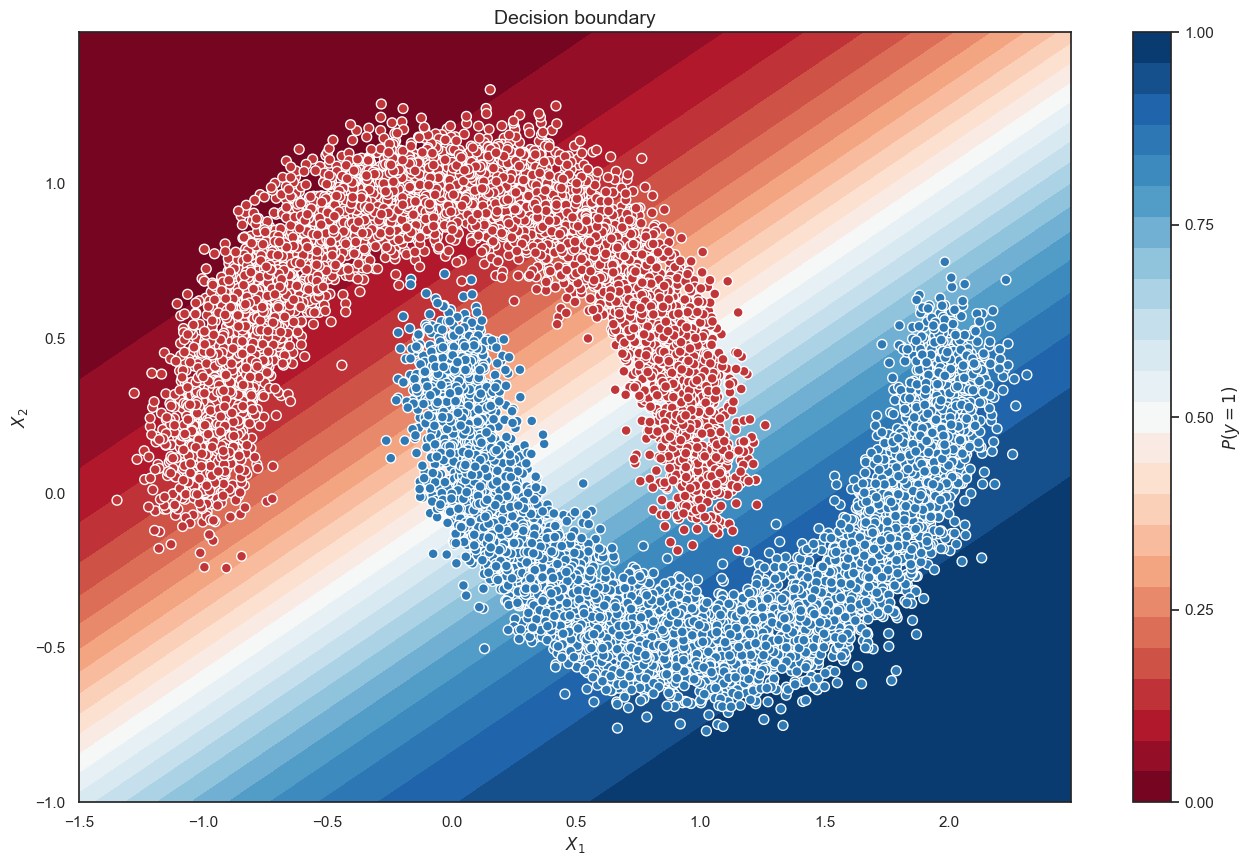

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model, threshold=0.5):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        x_batch = torch.tensor(x_batch, dtype=torch.float32)
        preds = linear_regression(x_batch)
        preds = (preds.view(-1) > threshold)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(predict(val_dataloader, linear_regression), y_val_t)
print('Accuracy is:', f'{round(acc * 100, 2)}')

Accuracy is: 86.0


C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1496885201.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch, dtype=torch.float32)


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 86%

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST

data_tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=100)
valid_dataloader =  DataLoader(val_dataset, batch_size=100)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [29]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128, bias=True),
    activation(),
    nn.Linear(128, 10, bias=True),
    nn.Softmax()
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [22]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))
            else:
                model.eval()
                with torch.no_grad():
                    outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))
            preds = outp.argmax(-1)
            correct = preds == y_batch
            all = len(x_batch)
            epoch_correct += correct.sum()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1621873338.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))
d:\Windows\Anaconda\envs\conda_py_env\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.8553000092506409


C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1621873338.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))


Loader: valid. Accuracy: 0.9068999886512756
Epoch: 2
Loader: train. Accuracy: 0.9124833345413208
Loader: valid. Accuracy: 0.9187999963760376
Epoch: 3
Loader: train. Accuracy: 0.9295833110809326
Loader: valid. Accuracy: 0.935699999332428
Epoch: 4
Loader: train. Accuracy: 0.9405666589736938
Loader: valid. Accuracy: 0.9473999738693237
Epoch: 5
Loader: train. Accuracy: 0.9505000114440918
Loader: valid. Accuracy: 0.9528999924659729


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [23]:
elu_accuracy = accuracy["valid"]

In [54]:
activations_list = {
    'ReLU':({
        'train':list(),
        'valid':list()
    }, nn.ReLU),
    'LeakyReLU':({
        'train':list(),
        'valid':list()
    }, nn.LeakyReLU),
    'NoActivation':({
        'train':list(),
        'valid':list()
    }, None)
}

class ModelActivation(nn.Module):
    def __init__(self, activation = None) -> None:
        super().__init__()
        if activation is not None:
            self.model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 128, bias=True),
                activation(),
                nn.Linear(128, 10, bias=True),
                nn.Softmax()
            )
        else:
            self.model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(784, 128, bias=True),
                nn.Linear(128, 10, bias=True),
                nn.Softmax()
            )

    def forward(self, x):
        return self.model(x)

criterion = nn.CrossEntropyLoss()
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [55]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for name, activation_lst in activations_list.items():
    activation = activation_lst[1]
    accuracy = activation_lst[0]
    model = ModelActivation(activation)
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))
                preds = outp.argmax(-1)
                correct = preds == y_batch
                all = len(x_batch)
                epoch_correct += correct.sum()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Activation: {name}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\3069788013.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))


Epoch: 1
Loader: train. Activation: ReLU. Accuracy: 0.8101666569709778


C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\3069788013.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outp = model.forward(torch.tensor(x_batch, dtype=torch.float32))


Loader: valid. Activation: ReLU. Accuracy: 0.9039000272750854
Epoch: 2
Loader: train. Activation: ReLU. Accuracy: 0.9122166633605957
Loader: valid. Activation: ReLU. Accuracy: 0.923799991607666
Epoch: 3
Loader: train. Activation: ReLU. Accuracy: 0.9273166656494141
Loader: valid. Activation: ReLU. Accuracy: 0.9307000041007996
Epoch: 4
Loader: train. Activation: ReLU. Accuracy: 0.9364833235740662
Loader: valid. Activation: ReLU. Accuracy: 0.9387000203132629
Epoch: 5
Loader: train. Activation: ReLU. Accuracy: 0.9440500140190125
Loader: valid. Activation: ReLU. Accuracy: 0.9434999823570251
Epoch: 1
Loader: train. Activation: LeakyReLU. Accuracy: 0.8388500213623047
Loader: valid. Activation: LeakyReLU. Accuracy: 0.9053000211715698
Epoch: 2
Loader: train. Activation: LeakyReLU. Accuracy: 0.9120833277702332
Loader: valid. Activation: LeakyReLU. Accuracy: 0.9235000014305115
Epoch: 3
Loader: train. Activation: LeakyReLU. Accuracy: 0.9279833436012268
Loader: valid. Activation: LeakyReLU. Accurac

In [59]:
plain_accuracy = activations_list['NoActivation'][0]['valid']
relu_accuracy = activations_list['ReLU'][0]['valid']
leaky_relu_accuracy = activations_list['LeakyReLU'][0]['valid']

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

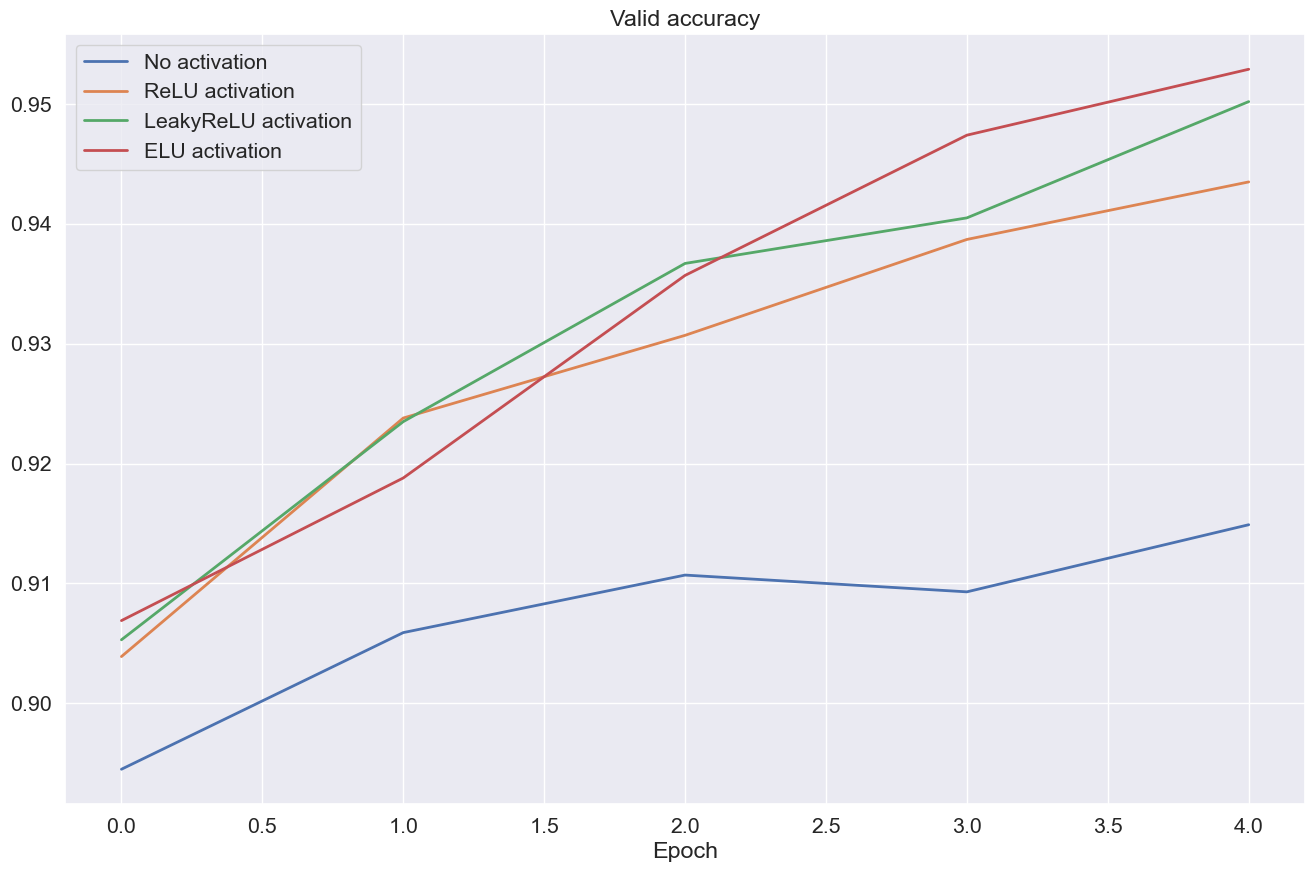

In [60]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

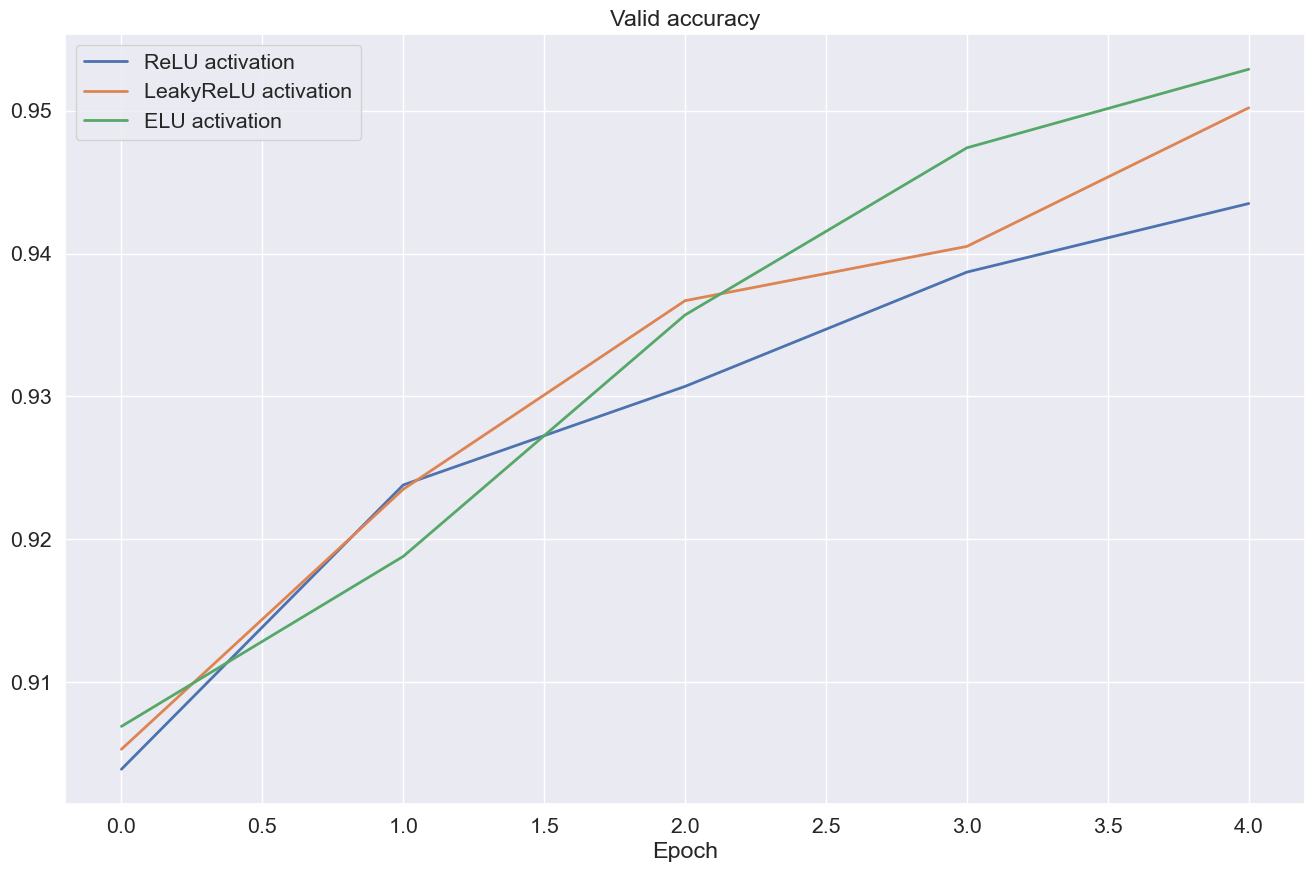

In [61]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU activation

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

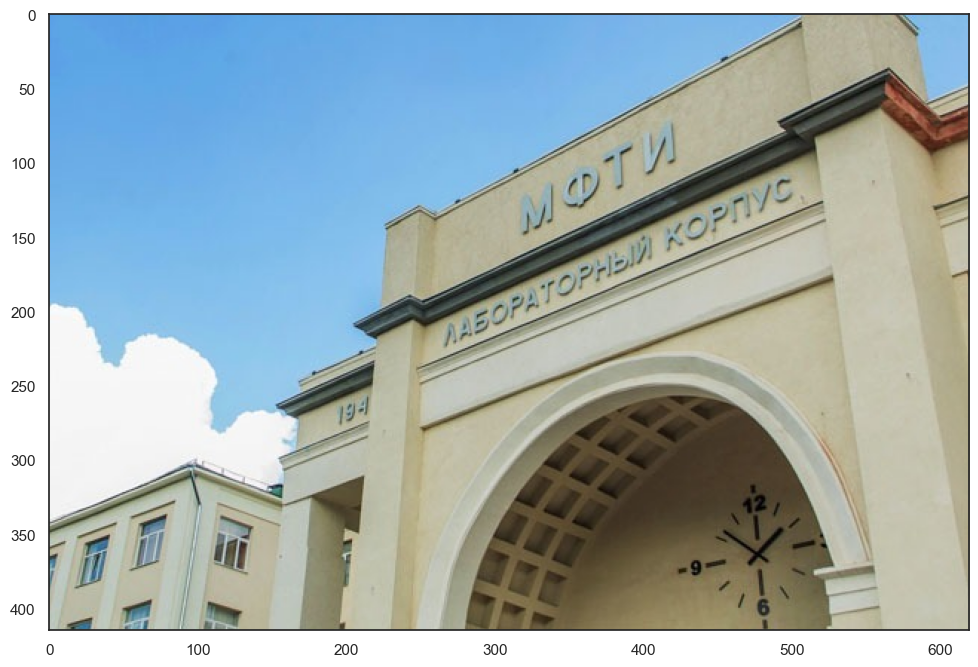

In [67]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

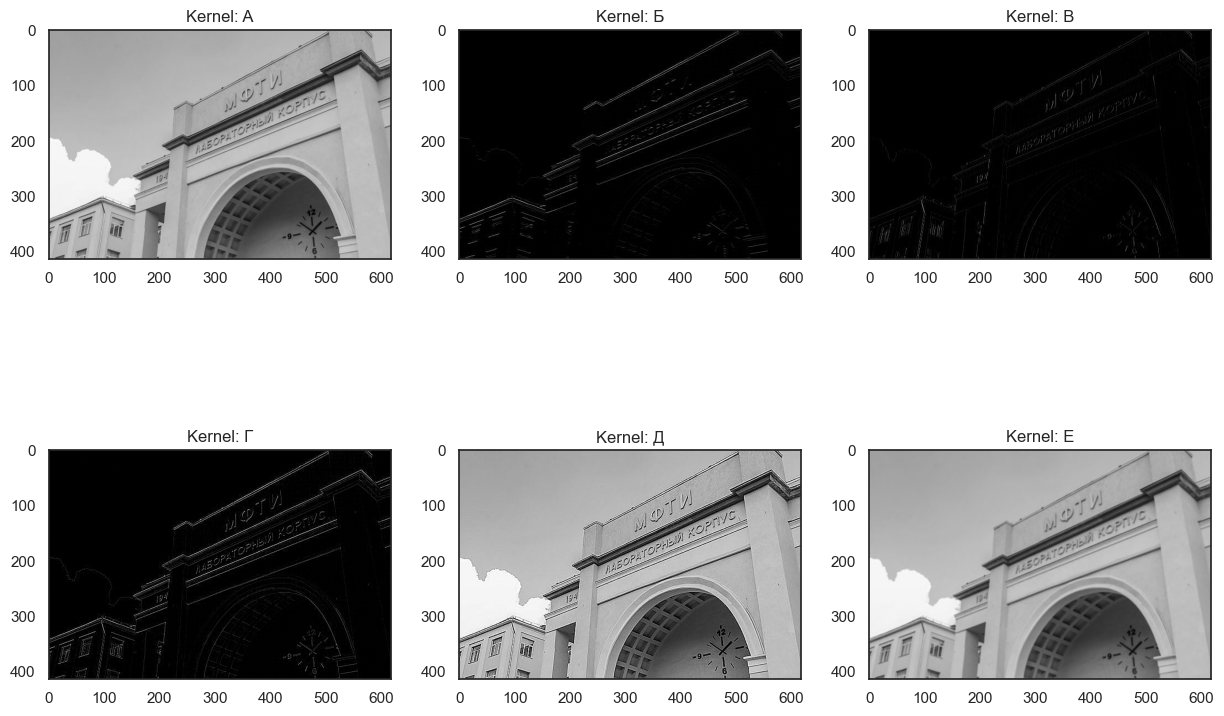

In [96]:
kernels = [
    torch.tensor([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 1, 0],
        [0, -2, 0],
        [0, 1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 0, 0],
        [1, -2, 1],
        [0, 0, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
    torch.tensor([
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]
    ]).reshape(1, 1, 3, 3).type(torch.float32),
]

rows = 2
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(15,10))

idx2kernel = {
    1:'A',
    2:'Б',
    3:'В',
    4:'Г',
    5:'Д',
    6:'Е'
}

for idx, kernel in enumerate(kernels):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]

    result = F.conv2d(img_t, kernel, padding=0)[0]

    # plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    result_np = np.clip(result_np, 0, 1)

    ax[idx // (rows + 1)][idx % cols].imshow(result_np)
    ax[idx // (rows + 1)][idx % cols].set(title=f'Kernel: {idx2kernel[idx + 1]}')

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 

3 - A 

5 - Б 

4 - В 

6 - Г 

1 - Е 

2 - Д

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [103]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.reveal = nn.Flatten()
        self.fc1 = nn.Linear(400, 120, bias=True)
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)

        x = self.reveal(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [104]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [108]:
max_epochs = 5
accuracy = {
    'train':list(),
    'valid':list()
}
for _ in range(max_epochs):
    epoch_correct = 0
    all_epoch = 0
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            x_batch = torch.tensor(x_batch, dtype=torch.float32)
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                outputs = model.forward(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model.forward(x_batch)
            preds = outputs.argmax(-1)
            epoch_correct += (preds == y_batch).sum()
            all_epoch += len(x_batch)
            if k == 'train':
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        accuracy[k].append(epoch_correct/all_epoch)


C:\Users\new_m\AppData\Local\Temp\ipykernel_16764\1808478791.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_batch, dtype=torch.float32)


In [109]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

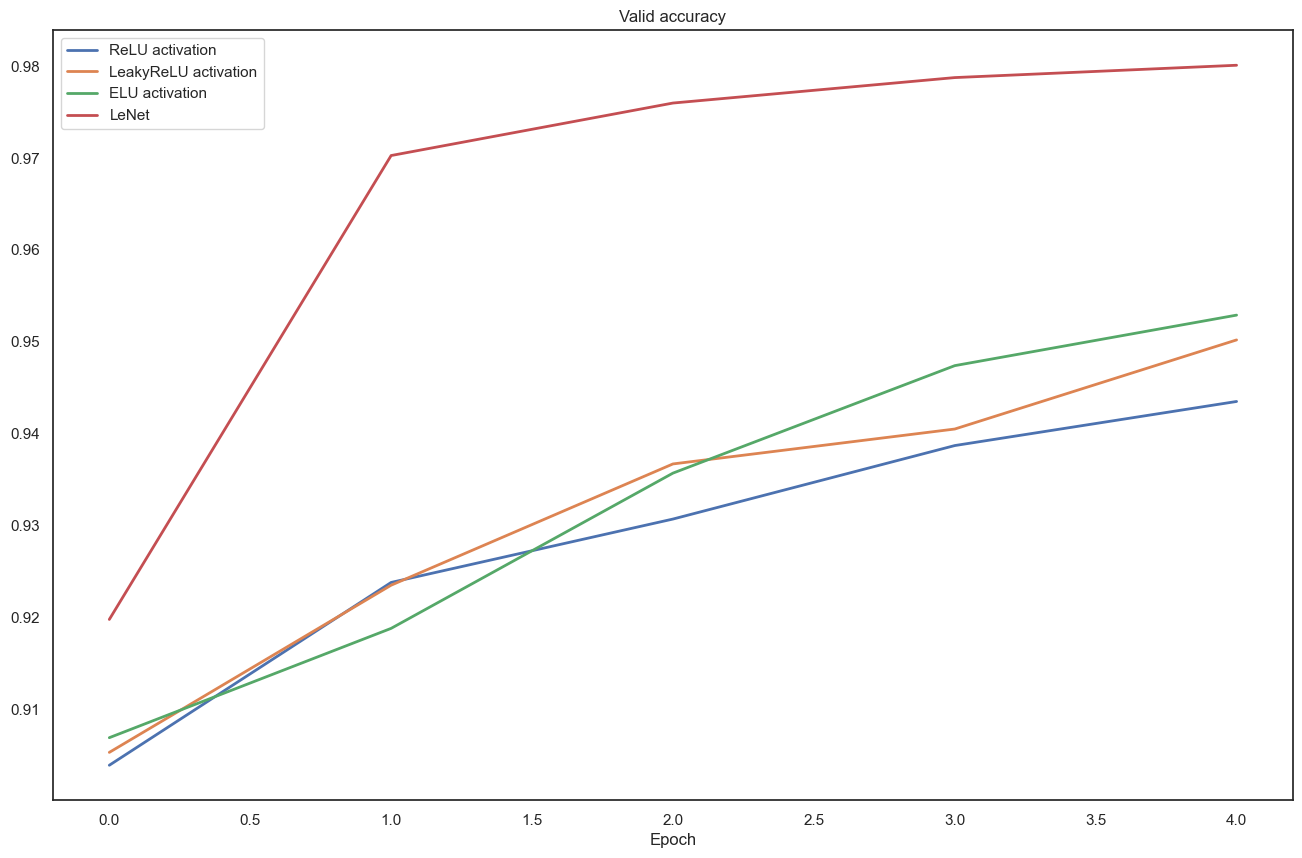

In [110]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [111]:
max(lenet_accuracy)

tensor(0.9801)

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 98%